<a href="https://colab.research.google.com/github/miramnair/Mars-Curiosity-Rover-Image-Classification/blob/main/7150CEM_DataScience_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
print(sys.version)


3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [ ]:
!nvidia-smi

import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print("RAM: {:.2f} GB".format(ram_gb))


Sat Jul 15 04:11:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

26G


In [ ]:
import psutil

# CPU usage
cpu_percent = psutil.cpu_percent(interval=1)
print("CPU Usage:", cpu_percent, "%")

# Memory usage
memory = psutil.virtual_memory()
print("Memory Usage:")
print("Total:", memory.total / 1e9, "GB")
print("Available:", memory.available / 1e9, "GB")
print("Used:", memory.used / 1e9, "GB")
print("Percentage:", memory.percent, "%")

# Disk usage
disk = psutil.disk_usage('/')
print("Disk Usage:")
print("Total:", disk.total / 1e9, "GB")
print("Used:", disk.used / 1e9, "GB")
print("Free:", disk.free / 1e9, "GB")
print("Percentage:", disk.percent, "%")

# Network usage
network = psutil.net_io_counters()
print("Network Usage:")
print("Bytes Sent:", network.bytes_sent)
print("Bytes Received:", network.bytes_recv)


CPU Usage: 10.3 %
Memory Usage:
Total: 27.328192512 GB
Available: 25.595260928 GB
Used: 1.360109568 GB
Percentage: 6.3 %
Disk Usage:
Total: 179.072380928 GB
Used: 26.007842816 GB
Free: 153.047760896 GB
Percentage: 14.5 %
Network Usage:
Bytes Sent: 553262
Bytes Received: 736864


**Import Libraries**

In [ ]:
import tensorflow as tf
import os.path as osp
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Cropping2D, Activation, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, concatenate, Reshape
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Activation, Multiply, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, Activation, MaxPooling2D, BatchNormalization,
    Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, multiply,
    Concatenate, Layer, Lambda
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
import datetime
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras import regularizers



In [ ]:
import sys
print("Python version:", sys.version)
print("keras version:", keras.__version__)


Python version: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
keras version: 2.12.0


In [ ]:
#set current directory path
os.chdir('/content/drive/MyDrive/msl-images')
cwd = os.getcwd()
print(cwd)

/content/drive/MyDrive/msl-images


In [ ]:
from tables import file
def read_file_path(name):
  input_path = osp.join('/content/drive/MyDrive/msl-images',name + '-calibrated-shuffled.txt')
  df = pd.read_csv(input_path, header=None)
  #split the string and create a new column
  df[['images','labels']] = df[0].str.split(' ', 1, expand=True)
  df['labels'] = pd.to_numeric(df['labels'])
  df = df.drop(0, axis=1)
  images = df.iloc[:, 0].values
  labels = df.iloc[:, 1].values
  dataset = tf.data.Dataset.from_tensor_slices((images,labels))
  return(dataset)
#load train dataset
train_data = read_file_path('train')
#load test dataset
test_data = read_file_path('test')
#load validation datset
val_data = read_file_path('val')


<ipython-input-4-0418cff57bb2>:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['images','labels']] = df[0].str.split(' ', 1, expand=True)
<ipython-input-4-0418cff57bb2>:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['images','labels']] = df[0].str.split(' ', 1, expand=True)
<ipython-input-4-0418cff57bb2>:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['images','labels']] = df[0].str.split(' ', 1, expand=True)


In [ ]:
def preprocess_image(image_path, label):
    """Define the function to read and preprocess the image
    Preprocessing including resizing, scaling, and data augmentation"""
    image = tf.io.read_file(image_path)
    #decode image and set channels = 3 (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    #resize image
    image = tf.image.resize(image, [new_height, new_width])
    #normalize image pixels
    image = image / 255.0

    return image, label


new_height = 224
new_width = 224
#new_height = 124
#new_width = 124
#new_height = 228
#new_width = 228

#preprocess the images
train_data_processed = train_data.map(preprocess_image)
test_data_processed = test_data.map(preprocess_image)
val_data_processed = val_data.map(preprocess_image)


**Count the number of images under each label and plot a graph**

In [ ]:
class_counts = {}
total_count = 0

#count the occurrences of each class
for _, label in train_data_processed:
    label = label.numpy()
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1
    total_count += 1
class_counts

{15: 85,
 8: 2343,
 21: 166,
 9: 224,
 2: 15,
 20: 57,
 10: 165,
 13: 36,
 4: 19,
 14: 101,
 17: 73,
 3: 47,
 23: 178,
 24: 69,
 7: 8,
 0: 30,
 12: 32,
 16: 18,
 5: 36,
 1: 6,
 19: 12,
 11: 14,
 6: 4,
 18: 8}

In [ ]:
class_counts_sorted = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))
#add description of labels
updated_dict = {
    0: 'apxs',
    1: 'apxs cal target',
    2: 'chemcam cal target',
    3: 'chemin inlet open',
    4: 'drill',
    5: 'drill holes',
    6: 'drt front',
    7: 'drt side',
    8: 'ground',
    9: 'horizon',
    10: 'inlet',
    11: 'mahli',
    12: 'mahli cal target',
    13: 'mastcam',
    14: 'mastcam cal target',
    15: 'observation tray',
    16: 'portion box',
    17: 'portion tube',
    18: 'portion tube opening',
    19: 'rems uv sensor',
    20: 'rover rear deck',
    21: 'scoop',
    22: 'sun',
    23: 'turret',
    24: 'wheel'
}

#sort
replaced_dict = {updated_dict[key]: value for key, value in class_counts_sorted.items()}


replaced_dict

{'ground': 2343,
 'horizon': 224,
 'turret': 178,
 'scoop': 166,
 'inlet': 165,
 'mastcam cal target': 101,
 'observation tray': 85,
 'portion tube': 73,
 'wheel': 69,
 'rover rear deck': 57,
 'chemin inlet open': 47,
 'mastcam': 36,
 'drill holes': 36,
 'mahli cal target': 32,
 'apxs': 30,
 'drill': 19,
 'portion box': 18,
 'chemcam cal target': 15,
 'mahli': 14,
 'rems uv sensor': 12,
 'drt side': 8,
 'portion tube opening': 8,
 'apxs cal target': 6,
 'drt front': 4}

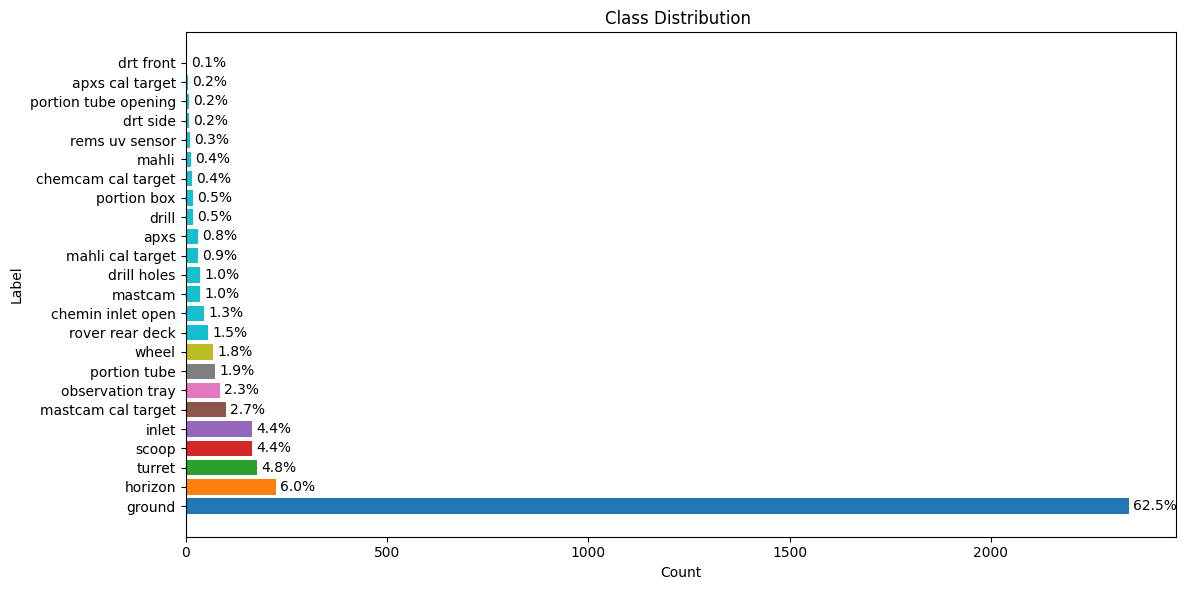

In [ ]:
labels = list(replaced_dict.keys())
counts = list(replaced_dict.values())

#create a bar plot
colors = cm.tab10(np.arange(len(labels)))
fig, ax = plt.subplots(figsize=(12, 6))
bar = ax.barh(labels, counts, color=colors)
plt.ylabel('Label')
plt.xlabel('Count')
plt.title('Class Distribution ')

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)


#add class percentage labels
for i, rect in enumerate(bar):
    width = rect.get_width()
    percentage = (counts[i] / total_count) * 100
    ax.annotate(f'{percentage:.1f}%', xy=(width, rect.get_y() + rect.get_height() / 2), xytext=(3, 0),
                textcoords='offset points', ha='left', va='center')

plt.tight_layout()
plt.show()

**Augment images which have very few samples**

In [ ]:
augmented_labels = [6, 1, 18, 7, 19, 11, 2, 16, 4, 0, 12, 5, 13, 3, 20, 24, 17]

train_images_new = []
train_labels_new = []

for image, label in train_data_processed:
    if label in augmented_labels:
        train_images_new.append(image)
        train_labels_new.append(label)

train_data_processed_new = tf.data.Dataset.from_tensor_slices((train_images_new, train_labels_new))


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
def augment_image1(image, label):
    """Define the function to apply data augmentation to the image : flip"""
    data_augmentation = tf.keras.Sequential([
        preprocessing.RandomFlip("horizontal_and_vertical")
    ])
    image = data_augmentation(image)

    return image, label

def augment_image2(image, label):
    """Define the function to apply data augmentation to the image : rotate"""
    data_augmentation = tf.keras.Sequential([
        preprocessing.RandomRotation(0.3)
    ])
    image = data_augmentation(image)

    return image, label

def augment_image3(image, label):
    """Define the function to apply data augmentation to the image : contrast"""
    data_augmentation = tf.keras.Sequential([
        preprocessing.RandomContrast(0.8, 1.2)
    ])

    image = data_augmentation(image)

    return image, label

def augment_image4(image, label):
    """Define the function to apply data augmentation to the image : zoom"""
    data_augmentation = tf.keras.Sequential([
        preprocessing.RandomZoom(0.2)
    ])
    image = data_augmentation(image)

    return image, label


#augment the training data
train_data_augmented1 = train_data_processed_new.map(augment_image1)
train_data_augmented2 = train_data_processed_new.map(augment_image2)
train_data_augmented3 = train_data_processed_new.map(augment_image3)
train_data_augmented4 = train_data_processed_new.map(augment_image4)



In [ ]:
#concatenate augmented training data with original data
train_data_combined = train_data_processed.concatenate(train_data_augmented1).concatenate(train_data_augmented2).concatenate(train_data_augmented3).concatenate(train_data_augmented4)

#Shuffle the images
train_data_combined = train_data_combined.shuffle(buffer_size=1000)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Repeat the steps to plot the new bar graph after data augmentataion**

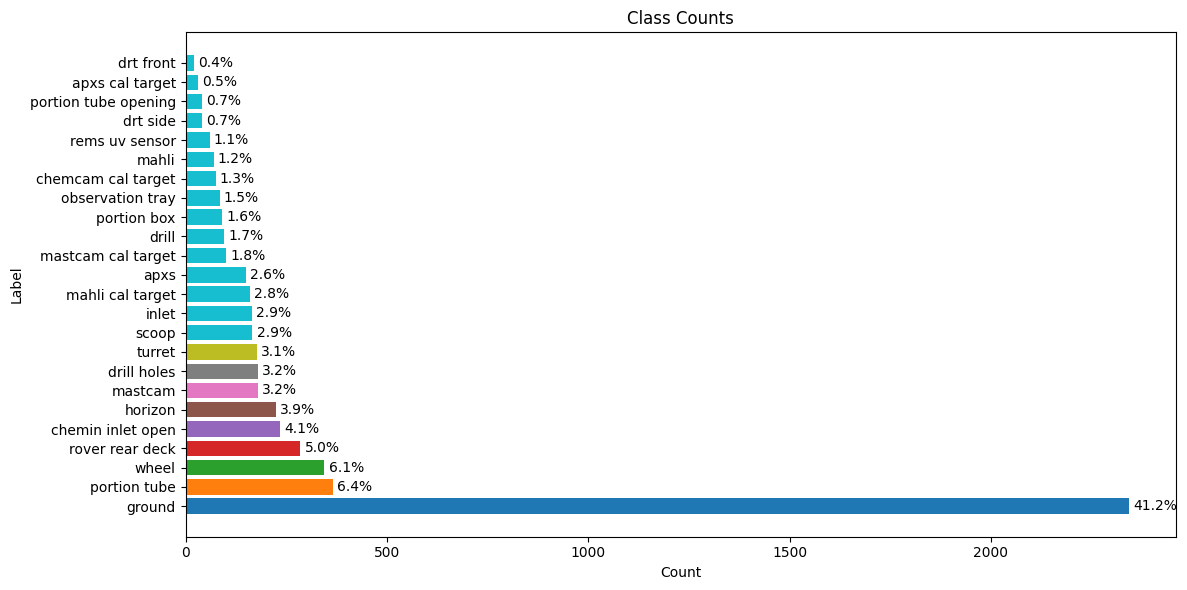

In [ ]:
class_counts = {}
total_count = 0

#count the occurrences of each class
for _, label in train_data_combined:
    label = label.numpy()
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1
    total_count += 1


class_counts_sorted = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))
#add description of labels
updated_dict = {
    0: 'apxs',
    1: 'apxs cal target',
    2: 'chemcam cal target',
    3: 'chemin inlet open',
    4: 'drill',
    5: 'drill holes',
    6: 'drt front',
    7: 'drt side',
    8: 'ground',
    9: 'horizon',
    10: 'inlet',
    11: 'mahli',
    12: 'mahli cal target',
    13: 'mastcam',
    14: 'mastcam cal target',
    15: 'observation tray',
    16: 'portion box',
    17: 'portion tube',
    18: 'portion tube opening',
    19: 'rems uv sensor',
    20: 'rover rear deck',
    21: 'scoop',
    22: 'sun',
    23: 'turret',
    24: 'wheel'
}

#sort
replaced_dict = {updated_dict[key]: value for key, value in class_counts_sorted.items()}

labels = list(replaced_dict.keys())
counts = list(replaced_dict.values())

#bar plot
colors = cm.tab10(np.arange(len(labels)))
fig, ax = plt.subplots(figsize=(12, 6))
bar = ax.barh(labels, counts, color=colors)
plt.ylabel('Label')
plt.xlabel('Count')
plt.title('Class Counts')

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)


#add class percentage labels
for i, rect in enumerate(bar):
    width = rect.get_width()
    percentage = (counts[i] / total_count) * 100
    ax.annotate(f'{percentage:.1f}%', xy=(width, rect.get_y() + rect.get_height() / 2), xytext=(3, 0),
                textcoords='offset points', ha='left', va='center')

plt.tight_layout()
plt.show()

In [ ]:
#batch the images
tf.random.set_seed(1234)
#batch_size = 32
#batch_size = 64
batch_size = 124
train_data_batched = train_data_combined.batch(batch_size)
val_data_batched = val_data_processed.batch(batch_size)
test_data_batched = test_data_processed.batch(batch_size)

In [ ]:
#pick one batch
for images, labels in test_data_batched.take(1):
    original_image = images[0]  # Choose the first image from the batch

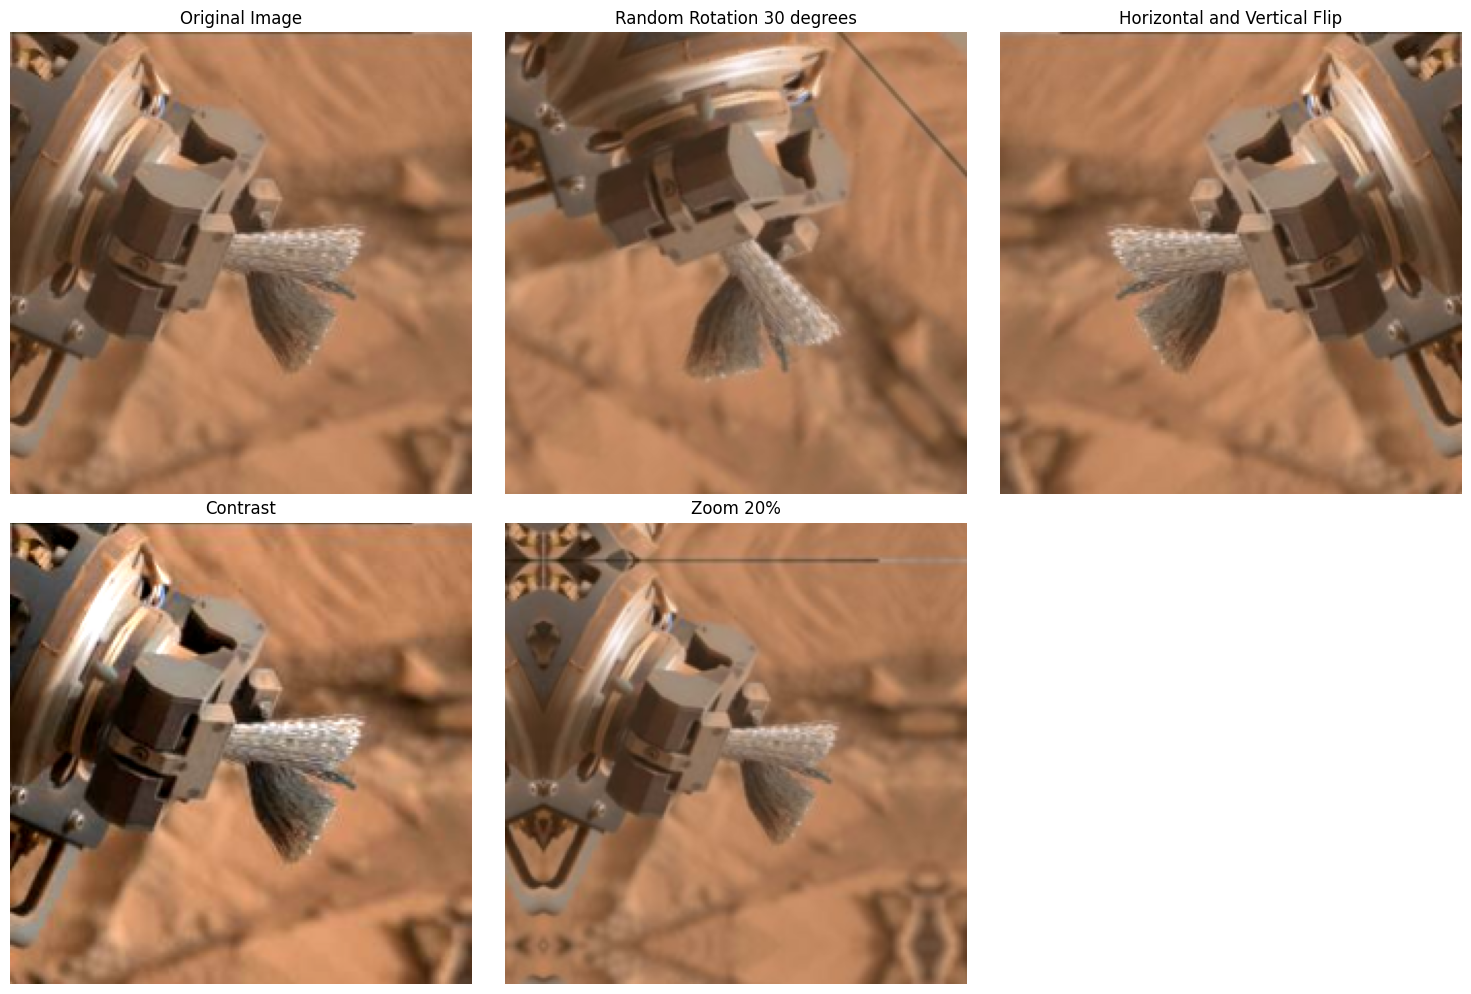

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot original image
axs[0, 0].imshow(original_image)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

#Augmentations
augmentations = [
    (preprocessing.RandomRotation(0.3), 'Random Rotation 30 degrees'),
    (preprocessing.RandomFlip("horizontal_and_vertical"), 'Horizontal and Vertical Flip'),
    (preprocessing.RandomContrast(0.8), 'Contrast'),
    (preprocessing.RandomZoom(0.2), 'Zoom 20%')
]

#
for i, (augmentation, title) in enumerate(augmentations):
    data_augmentation = tf.keras.Sequential([augmentation])
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0))
    augmented_image = augmented_image[0].numpy()
    axs[(i+1)//3, (i+1)%3].imshow(augmented_image)
    axs[(i+1)//3, (i+1)%3].set_title(title)
    axs[(i+1)//3, (i+1)%3].axis('off')


if len(augmentations) < 5:
    for j in range(len(augmentations)+1, 6):
        fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()


In [ ]:
train_data_combined

<_ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

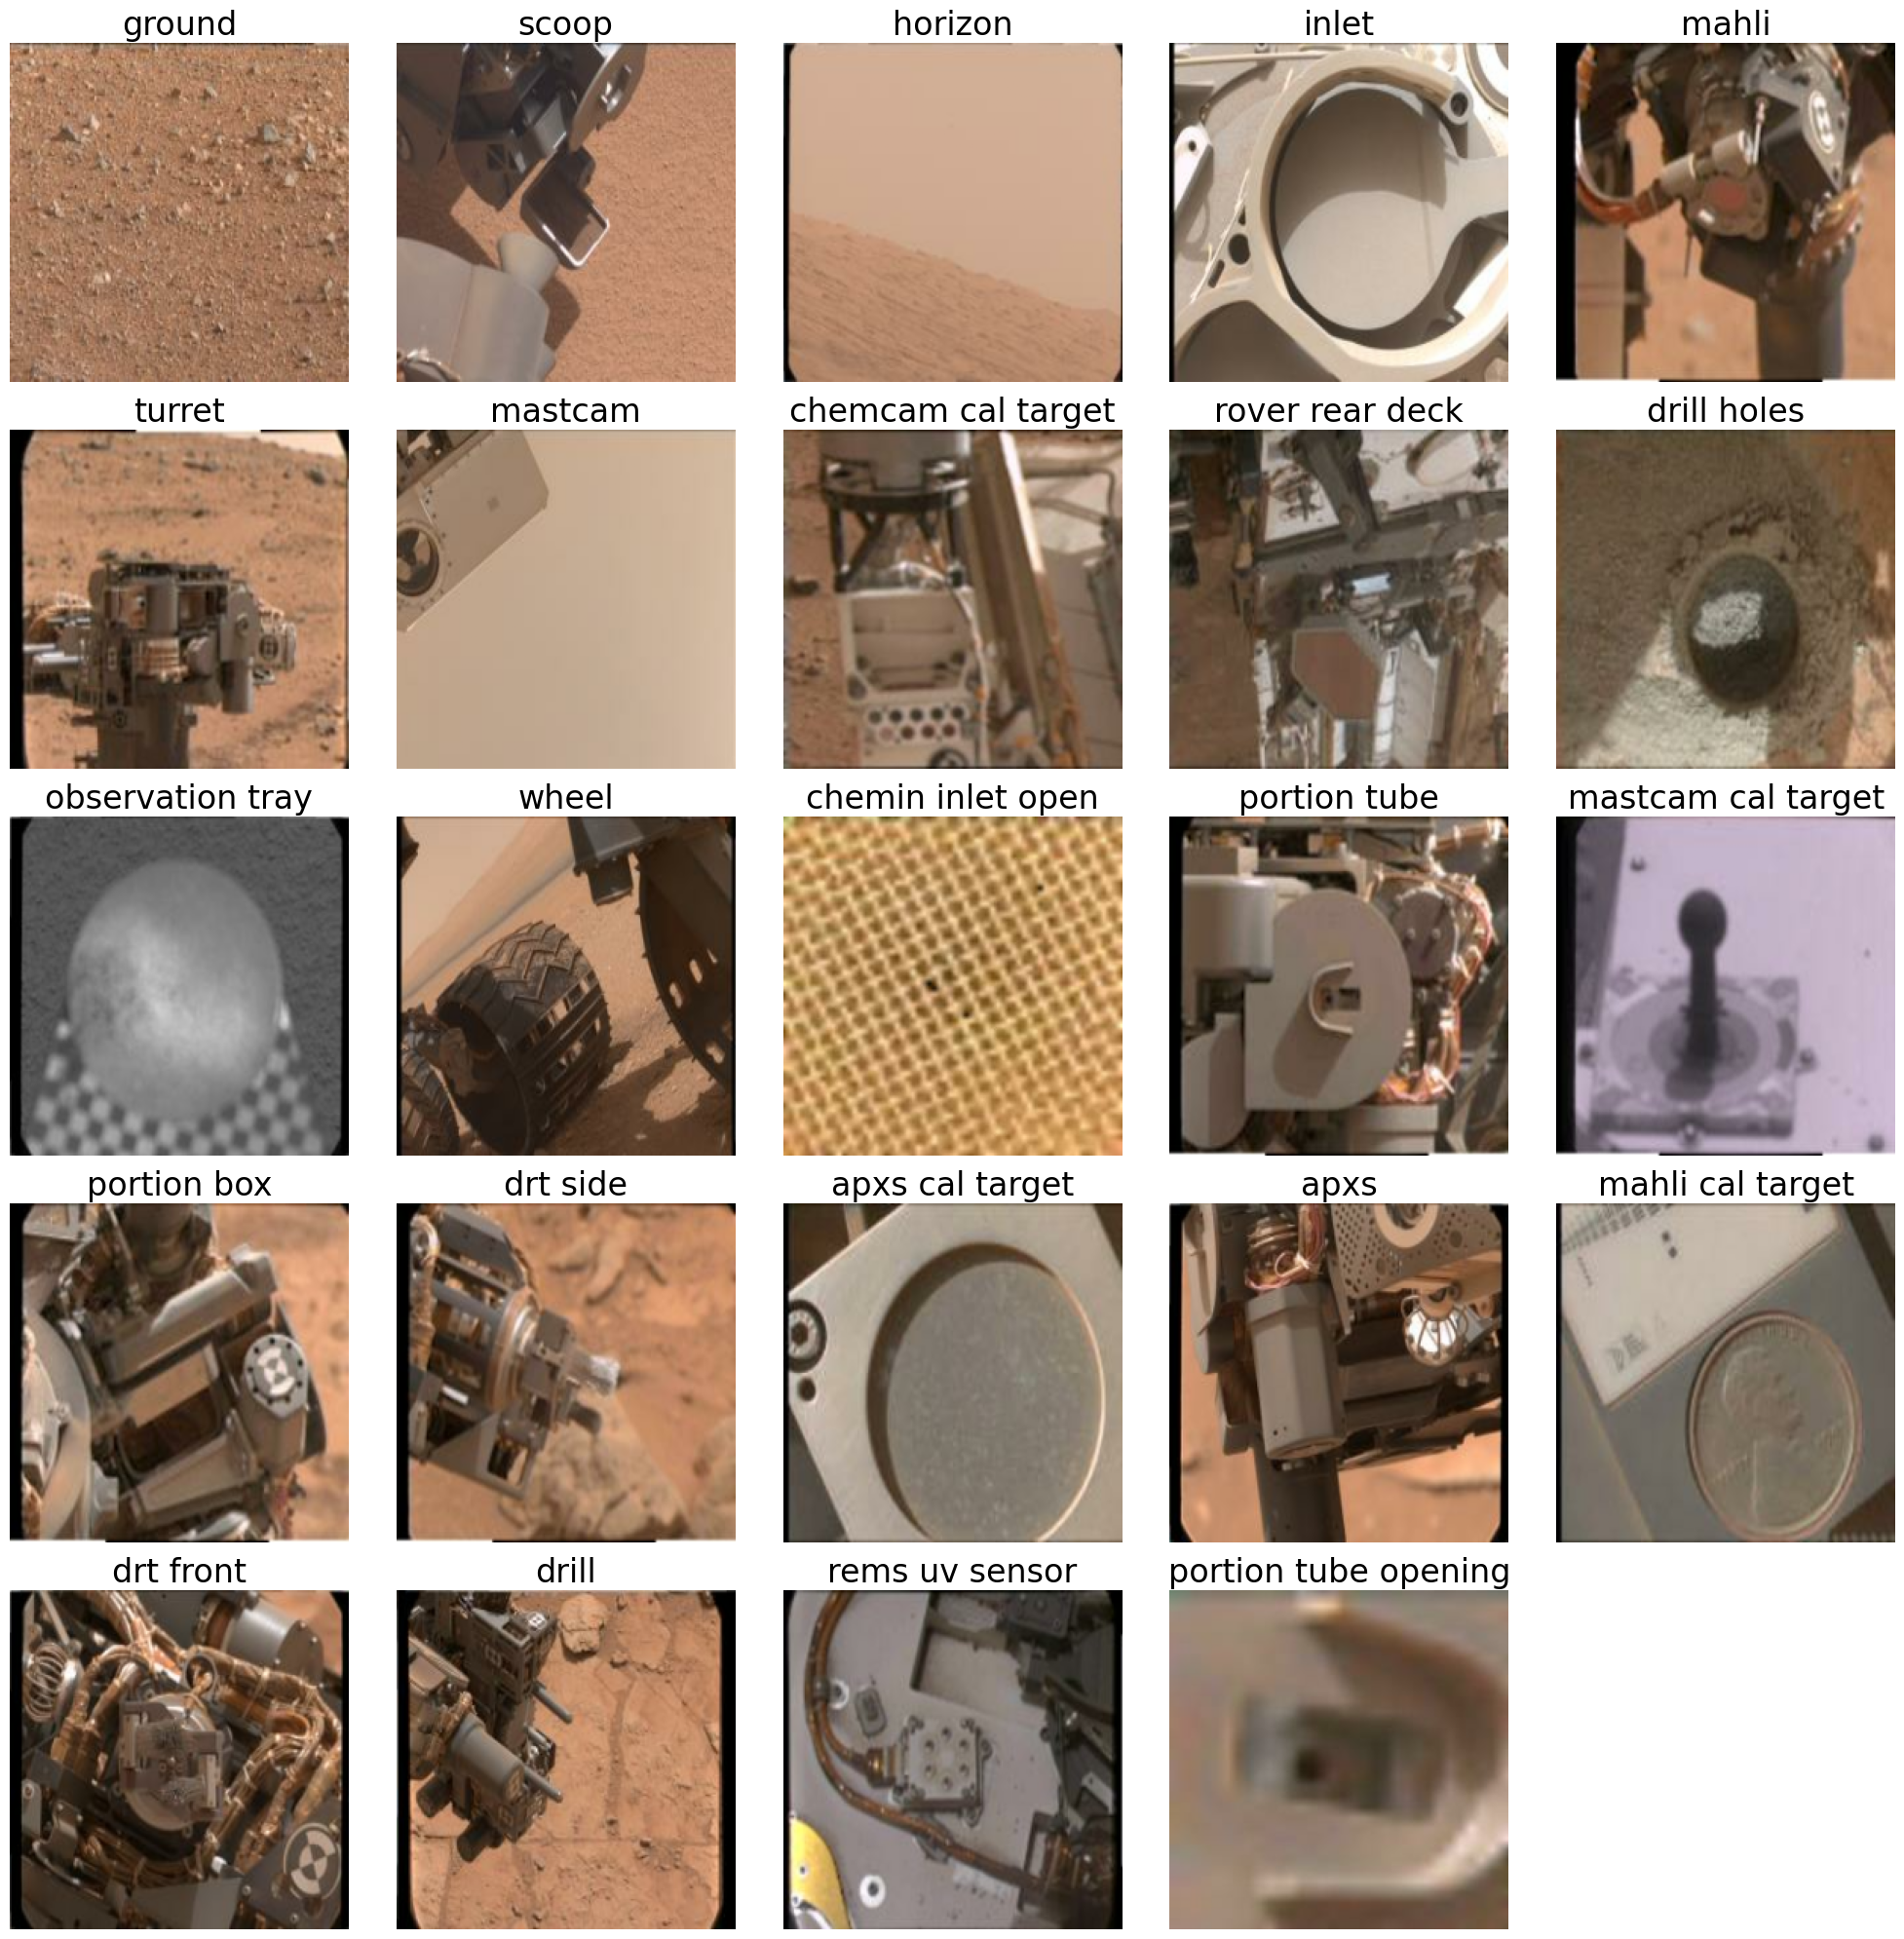

In [ ]:
#get each image
example_images = {}
for images, labels in train_data_combined:
    label = labels.numpy()
    if label not in example_images:
        example_images[label] = images

replaced_dict_images = {updated_dict[key]: value for key, value in example_images.items()}

#plot
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
axs = axs.ravel()

for i, (label, image) in enumerate(replaced_dict_images.items()):
    axs[i].imshow(image)
    axs[i].set_title(label, fontsize=24)
    axs[i].axis('off')


if len(replaced_dict_images) < 25:
    for j in range(len(replaced_dict_images), 25):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


# **Just CNN without CBAM (224x224x3) and batch size = 124**

In [ ]:
# model
model = tf.keras.Sequential()

#1st Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=64, input_shape=(224, 224, 3), kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#2nd Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#3rd Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#4th Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#5th Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#Flatten the output
model.add(tf.keras.layers.Flatten())

#Fully Connected Layer2
model.add(tf.keras.layers.Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

#Fully Connected Layer3
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

#Output Layer
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 activation_8 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 batch_normalization_7 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 activation_9 (Activation)   (None, 112, 112, 128)    

In [ ]:
#compile the model

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#create log directory for TensorBoard
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#define tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#create the model checkpoint callback to save the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_cnn.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0.000001
)

#list all the callbacks
callback_list = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]

In [ ]:
tf.random.set_seed(1234)
CNN_train = model.fit(train_data_batched,
                    epochs=50,
                    validation_data=val_data_batched,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 12.4176 - accuracy: 0.6566
Epoch 1: val_accuracy improved from -inf to 0.04573, saving model to ./best_model_cnn.h5
46/46 [==============================] - 20s 371ms/step - loss: 12.4176 - accuracy: 0.6566 - val_loss: 13.9526 - val_accuracy: 0.0457 - lr: 1.0000e-04
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 11.3528 - accuracy: 0.7842
Epoch 2: val_accuracy improved from 0.04573 to 0.05061, saving model to ./best_model_cnn.h5
46/46 [==============================] - 18s 370ms/step - loss: 11.3528 - accuracy: 0.7842 - val_loss: 13.4735 - val_accuracy: 0.0506 - lr: 1.0000e-04
Epoch 3/50
46/46 [==============================] - ETA: 0s - loss: 10.5912 - accuracy: 0.8427
Epoch 3: val_accuracy did not improve from 0.05061
46/46 [==============================] - 17s 343ms/step - loss: 10.5912 - accuracy: 0.8427 - val_loss: 12.6649 - val_accuracy: 0.0457 - lr: 1.0000e-04
Epoch 4/50
46/46 [============

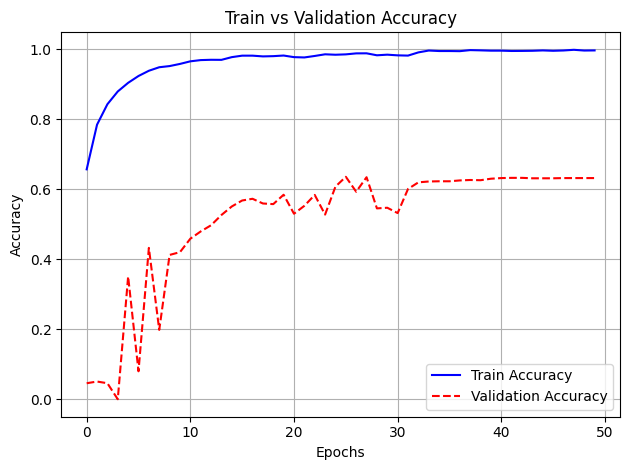

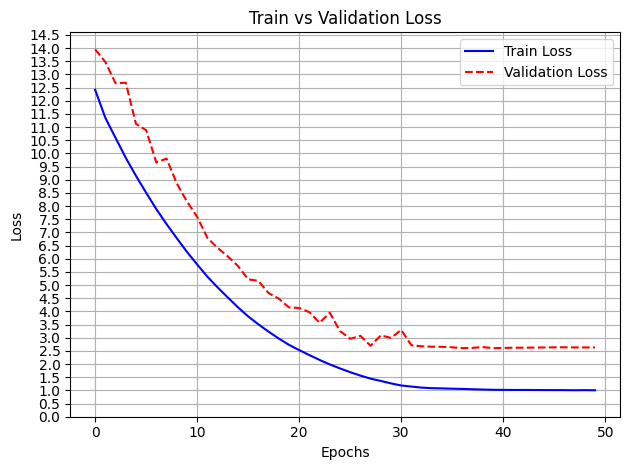

In [ ]:
train_accuracy = CNN_train.history['accuracy']
val_accuracy = CNN_train.history['val_accuracy']
train_loss = CNN_train.history['loss']
val_loss = CNN_train.history['val_loss']

# Accuracy plot
plt.plot(train_accuracy, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot
plt.plot(train_loss, label='Train Loss', color='blue', linestyle='-')
plt.plot(val_loss, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
y_ticks = np.arange(0, max(max(train_loss), max(val_loss)) + 1, .5)
plt.yticks(y_ticks)
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

best_model = tf.keras.models.load_model('./best_model_cnn.h5')

#evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_data_batched)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

#evaluate the best model on the test dataset
train_loss, train_accuracy = best_model.evaluate(train_data_batched)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


#evaluate the best model on the test dataset
val_loss, val_accuracy = best_model.evaluate(val_data_batched)

print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

11/11 [==============================] - 1s 94ms/step - loss: 4.8103 - accuracy: 0.4176
Test Loss: 4.810328960418701
Test Accuracy: 0.4176245331764221
46/46 [==============================] - 11s 212ms/step - loss: 1.7374 - accuracy: 0.9516
Train Loss: 1.7374024391174316
Train Accuracy: 0.9516015648841858
14/14 [==============================] - 2s 105ms/step - loss: 2.9592 - accuracy: 0.6354
Val Loss: 2.9591870307922363
Val Accuracy: 0.6353658437728882


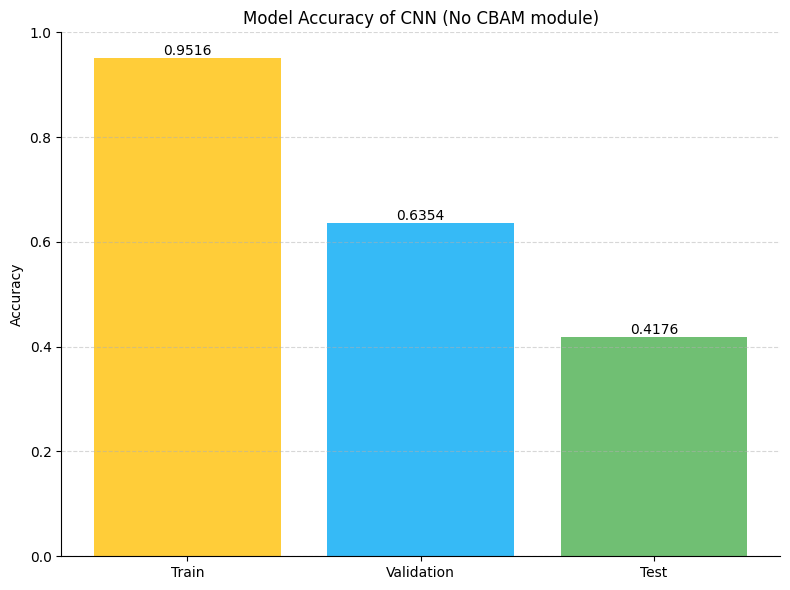

In [ ]:
datasets = ['Train', 'Validation', 'Test']
accuracies = [train_accuracy, val_accuracy, test_accuracy]


# bar plot
plt.figure(figsize=(8, 6))
x = range(len(datasets))
bars = plt.bar(x, accuracies, align='center', alpha=0.8, color=['#FFC107', '#03A9F4', '#4CAF50'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy of CNN (No CBAM module)')
plt.xticks(x, datasets)
plt.ylim(0, 1)
# Data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#generate predictions
y_true = []
y_pred = []
for batch in test_data_batched:
    images, labels = batch
    predictions = best_model.predict(images)
    # convert predictionsprobabilities to class labels
    predictions = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

print(classification_report(y_true, y_pred))


3/3 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           0       0.47      0.85      0.60        34
           1       0.58      1.00      0.74        14
           2       0.83      0.24      0.37        21
           3       0.00      0.00      0.00        84
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        60
           7       1.00      0.01      0.03       150
           8       0.32      0.19      0.24       254
           9       0.61      0.58      0.60        72
          10       0.00      0.00      0.00        16
          11       1.00      0.33      0.50        12
          12       0.22      0.79      0.35        57
          13       0.53      0.75      0.62        32
          14       1.00      0.58      0.74        48
          15       1.00      0.42      0.59        12
          16       0.38      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

# **CNN + CBAM (224x224x3) batch size = 124**

In [ ]:
class CBAMLayer(tf.keras.layers.Layer):
    """ This code defines the spatial attention and
    channel attention modules """
    def __init__(self, ratio=8):
        super(CBAMLayer, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        _, _, _, channel = input_shape

        self.l1 = tf.keras.layers.Dense(channel // self.ratio, activation="relu", use_bias=False)
        self.l2 = tf.keras.layers.Dense(channel, use_bias=False)
        self.conv = tf.keras.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")

    def call(self, inputs):
        x1 = tf.reduce_mean(inputs, axis=-1)
        x1 = tf.expand_dims(x1, axis=-1)
        x2 = tf.reduce_max(inputs, axis=-1)
        x2 = tf.expand_dims(x2, axis=-1)

        feats = tf.concat([x1, x2], axis=-1)
        feats = self.conv(feats)
        feats = tf.multiply(inputs, feats)

        x1 = tf.reduce_mean(inputs, axis=[1, 2])
        x2 = tf.reduce_max(inputs, axis=[1, 2])
        feats = tf.concat([x1, x2], axis=-1)
        feats = self.l1(feats)
        feats = self.l2(feats)
        feats = tf.sigmoid(feats)

        return tf.multiply(inputs, tf.expand_dims(tf.expand_dims(feats, 1), 1))


# model
model = tf.keras.Sequential()

#1st Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=64, input_shape=(224, 224, 3), kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#2nd Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#3rd Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#4th Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#5th Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#Apply CBAM
model.add(CBAMLayer())

#Flatten the output
model.add(tf.keras.layers.Flatten())

#Fully Connected Layer2
model.add(tf.keras.layers.Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

#Fully Connected Layer3
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

#Output Layer
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 activation_8 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 batch_normalization_7 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 activation_9 (Activation)   (None, 112, 112, 128)    

In [ ]:
#compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#create log directory for TensorBoard
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#define tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#create the model checkpoint callback to save the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_cnn_cbam.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0.0000001
)

#list all the callbacks
callback_list = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]

In [ ]:
tf.random.set_seed(1234)
CBAM_train = model.fit(train_data_batched,
                    epochs=50,
                    validation_data=val_data_batched,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/50


46/46 [==============================] - ETA: 0s - loss: 5.7006 - accuracy: 0.9588
Epoch 1: val_accuracy improved from -inf to 0.46707, saving model to ./best_model_cnn_cbam.h5
46/46 [==============================] - 19s 370ms/step - loss: 5.7006 - accuracy: 0.9588 - val_loss: 7.8835 - val_accuracy: 0.4671 - lr: 1.0000e-04
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 5.0285 - accuracy: 0.9509
Epoch 2: val_accuracy improved from 0.46707 to 0.48110, saving model to ./best_model_cnn_cbam.h5
46/46 [==============================] - 18s 368ms/step - loss: 5.0285 - accuracy: 0.9509 - val_loss: 6.5008 - val_accuracy: 0.4811 - lr: 1.0000e-04
Epoch 3/50
46/46 [==============================] - ETA: 0s - loss: 4.4817 - accuracy: 0.9627
Epoch 3: val_accuracy improved from 0.48110 to 0.49329, saving model to ./best_model_cnn_cbam.h5
46/46 [==============================] - 21s 433ms/step - loss: 4.4817 - accuracy: 0.9627 - val_loss: 5.9774 - val_accuracy: 0.4933 - lr: 1.000

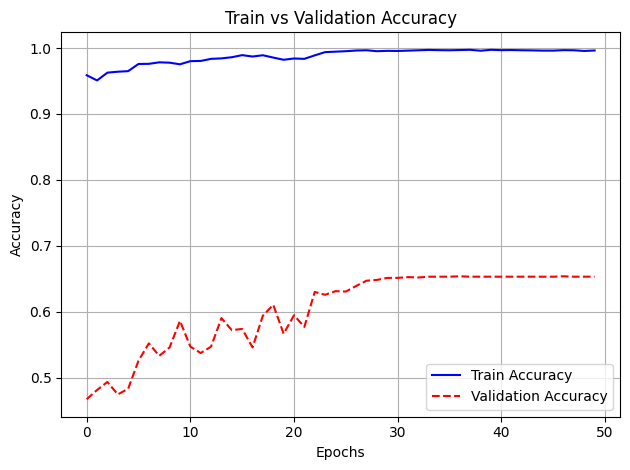

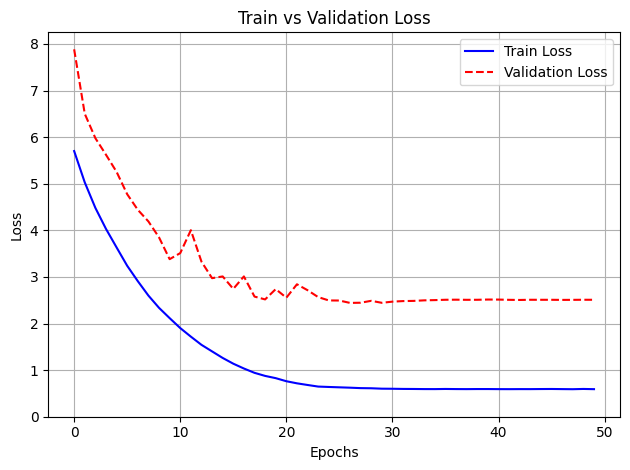

In [ ]:
train_accuracy = CBAM_train.history['accuracy']
val_accuracy = CBAM_train.history['val_accuracy']
train_loss = CBAM_train.history['loss']
val_loss = CBAM_train.history['val_loss']

# Accuracy plot
plt.plot(train_accuracy, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot
plt.plot(train_loss, label='Train Loss', color='blue', linestyle='-')
plt.plot(val_loss, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
y_ticks = np.arange(0, max(max(train_loss), max(val_loss)) + 1, 1)
plt.yticks(y_ticks)
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

with tf.keras.utils.custom_object_scope({'CBAMLayer': CBAMLayer}):
    best_model = tf.keras.models.load_model('./best_model_cnn_cbam.h5')

#evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_data_batched)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

#evaluate the best model on the test dataset
train_loss, train_accuracy = best_model.evaluate(train_data_batched)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


#evaluate the best model on the test dataset
val_loss, val_accuracy = best_model.evaluate(val_data_batched)

print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

11/11 [==============================] - 2s 175ms/step - loss: 2.7664 - accuracy: 0.5854
Test Loss: 2.766430139541626
Test Accuracy: 0.5854406356811523
46/46 [==============================] - 11s 213ms/step - loss: 0.5850 - accuracy: 0.9975
Train Loss: 0.5850425362586975
Train Accuracy: 0.9975360631942749
14/14 [==============================] - 1s 93ms/step - loss: 2.5112 - accuracy: 0.6537
Val Loss: 2.511223077774048
Val Accuracy: 0.6536585092544556


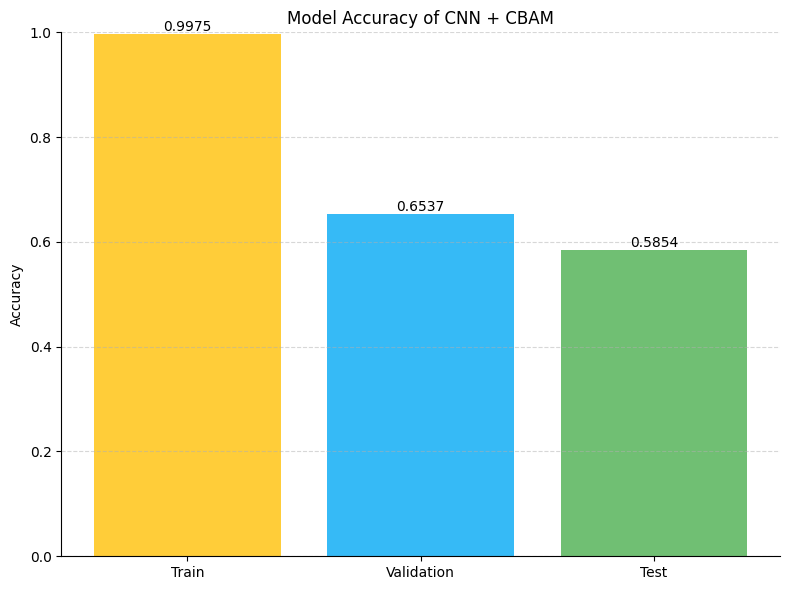

In [ ]:
datasets = ['Train', 'Validation', 'Test']
accuracies = [train_accuracy, val_accuracy, test_accuracy]


# bar plot
plt.figure(figsize=(8, 6))
x = range(len(datasets))
bars = plt.bar(x, accuracies, align='center', alpha=0.8, color=['#FFC107', '#03A9F4', '#4CAF50'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy of CNN + CBAM')
plt.xticks(x, datasets)
plt.ylim(0, 1)
# Data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#generate predictions
y_true = []
y_pred = []
for batch in test_data_batched:
    images, labels = batch
    predictions = best_model.predict(images)
    # convert predictionsprobabilities to class labels
    predictions = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

print(classification_report(y_true, y_pred))


3/3 [==============================] - 0s 78ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.65        34
           1       1.00      1.00      1.00        14
           2       0.60      0.29      0.39        21
           3       0.32      0.27      0.29        84
           4       0.19      0.45      0.27        20
           6       0.00      0.00      0.00        60
           7       1.00      0.35      0.51       150
           8       0.56      0.57      0.57       254
           9       1.00      0.61      0.76        72
          10       0.00      0.00      0.00        16
          11       1.00      0.58      0.74        12
          12       0.65      0.77      0.70        57
          13       0.84      0.81      0.83        32
          14       1.00      0.73      0.84        48
          15       0.91      0.83      0.87        12
          16       0.16      0.19      0.17        48
          17       0.54      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

# **Autoencoder Approach**

# **Attempt 1 - 224x224x3 batch size = 64**

In [ ]:
#remove labels
train_data = np.array(list(train_data_combined.map(lambda x, y: x)))

val_data = np.array(list(val_data_processed.map(lambda x, y: x)))


In [ ]:
train_data.shape, val_data.shape

((5682, 224, 224, 3), (1640, 224, 224, 3))

In [ ]:
batch_size = 32
epochs = 100
inChannel = 3
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))
num_classes = 25

def encoder(input_img):
    """ encoder """
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):
    """ decoder """
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up3 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded


In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0     

In [ ]:
autoencoder_train = autoencoder.fit(train_data, train_data, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(val_data, val_data))


Epoch 1/100
178/178 [==============================] - 37s 130ms/step - loss: 0.0135 - val_loss: 0.0873
Epoch 2/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0059 - val_loss: 0.0083
Epoch 3/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0042 - val_loss: 0.0191
Epoch 4/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0037 - val_loss: 0.0093
Epoch 5/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0033 - val_loss: 0.0137
Epoch 6/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0031 - val_loss: 0.0096
Epoch 7/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0030 - val_loss: 0.0219
Epoch 8/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0029 - val_loss: 0.0067
Epoch 9/100
178/178 [==============================] - 18s 102ms/step - loss: 0.0026 - val_loss: 0.0058
Epoch 10/100
178/178 [==============================] - 18s 102m

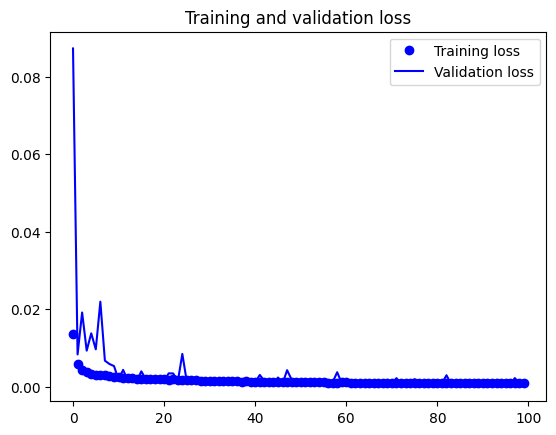

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.save_weights('autoencoder.h5')

In [ ]:
def encoder(input_img):
    """ encoder """
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [ ]:
def fc(encode):
    flat = Flatten()(encode)
    dense = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(dense)
    return out


In [ ]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))


In [ ]:
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0     

In [ ]:
for l1,l2 in zip(full_model.layers[:21],autoencoder.layers[0:21]):
    l1.set_weights(l2.get_weights())


In [ ]:
for layer in full_model.layers[0:21]:
    layer.trainable = False


In [ ]:
autoencoder.get_weights()[0][1]

array([[[ 1.02687635e-01,  1.93820581e-01,  6.24354407e-02,
         -1.11741610e-01,  2.31113091e-01,  1.69523329e-01,
         -4.22281861e-01,  1.08412579e-02, -6.26286641e-02,
         -7.71027952e-02,  6.58816751e-03, -4.61717606e-01,
         -2.07039863e-01,  8.16651434e-02,  9.51054692e-02,
          7.62656182e-02,  4.33386624e-01,  1.58483133e-01,
         -9.13449936e-03,  5.39917685e-02,  1.31435230e-01,
          1.69632077e-01,  2.48695076e-01,  5.13048358e-02,
         -6.92720264e-02,  2.88712144e-01, -7.80544952e-02,
         -1.09663839e-03, -8.86658728e-02, -1.94162522e-02,
         -1.05975382e-01, -8.11993405e-02],
        [-8.58571827e-02,  1.09961085e-01, -1.12077892e-01,
         -4.42896746e-02,  6.02402277e-02, -5.25608240e-03,
         -3.58869821e-01,  6.04466200e-01,  1.38141990e-01,
          2.41281874e-02,  8.73987973e-02, -4.71631140e-02,
         -1.64823562e-01,  2.14075819e-01,  2.88593382e-01,
          5.71905933e-02,  5.33869416e-02, -7.35871587e-

In [ ]:
full_model.get_weights()[0][1]

array([[[ 1.02687635e-01,  1.93820581e-01,  6.24354407e-02,
         -1.11741610e-01,  2.31113091e-01,  1.69523329e-01,
         -4.22281861e-01,  1.08412579e-02, -6.26286641e-02,
         -7.71027952e-02,  6.58816751e-03, -4.61717606e-01,
         -2.07039863e-01,  8.16651434e-02,  9.51054692e-02,
          7.62656182e-02,  4.33386624e-01,  1.58483133e-01,
         -9.13449936e-03,  5.39917685e-02,  1.31435230e-01,
          1.69632077e-01,  2.48695076e-01,  5.13048358e-02,
         -6.92720264e-02,  2.88712144e-01, -7.80544952e-02,
         -1.09663839e-03, -8.86658728e-02, -1.94162522e-02,
         -1.05975382e-01, -8.11993405e-02],
        [-8.58571827e-02,  1.09961085e-01, -1.12077892e-01,
         -4.42896746e-02,  6.02402277e-02, -5.25608240e-03,
         -3.58869821e-01,  6.04466200e-01,  1.38141990e-01,
          2.41281874e-02,  8.73987973e-02, -4.71631140e-02,
         -1.64823562e-01,  2.14075819e-01,  2.88593382e-01,
          5.71905933e-02,  5.33869416e-02, -7.35871587e-

In [ ]:
#define the log directory for TensorBoard
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#create log directory for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#define tensorboard callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_autoencoder.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0.0000001,
)

#list all the callbacks
callback_list = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]

#compile the model
optimizer = Adam(learning_rate=0.0001)
full_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [ ]:
tf.random.set_seed(1234)
encode_train = full_model.fit(train_data_batched,
                    epochs=50,
                    validation_data=val_data_batched,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 0.9415 - accuracy: 0.7967
Epoch 1: val_accuracy improved from -inf to 0.55854, saving model to ./best_model_autoencoder.h5
89/89 [==============================] - 16s 150ms/step - loss: 0.9415 - accuracy: 0.7967 - val_loss: 4.7046 - val_accuracy: 0.5585 - lr: 1.0000e-04
Epoch 2/50
88/89 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.9229
Epoch 2: val_accuracy did not improve from 0.55854
89/89 [==============================] - 12s 130ms/step - loss: 0.2983 - accuracy: 0.9227 - val_loss: 5.0917 - val_accuracy: 0.5244 - lr: 1.0000e-04
Epoch 3/50
88/89 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9535
Epoch 3: val_accuracy improved from 0.55854 to 0.59329, saving model to ./best_model_autoencoder.h5
89/89 [==============================] - 17s 187ms/step - loss: 0.1675 - accuracy: 0.9532 - val_loss: 4.3357 - val_accuracy: 0.5933 - lr: 1.0000e-04
Epoch 4/50
88/89 [=====

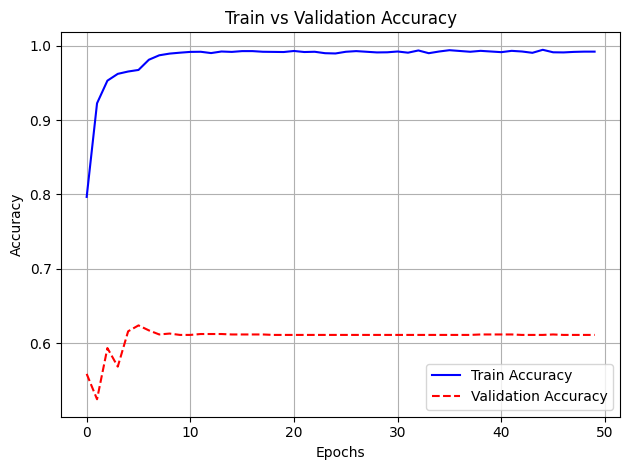

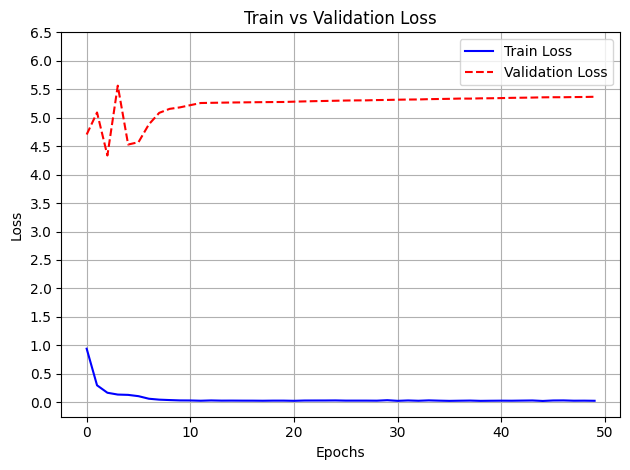

In [ ]:
  train_accuracy = encode_train.history['accuracy']
  val_accuracy = encode_train.history['val_accuracy']
  train_loss = encode_train.history['loss']
  val_loss = encode_train.history['val_loss']

  # Accuracy plot
  plt.plot(train_accuracy, label='Train Accuracy', color='blue', linestyle='-')
  plt.plot(val_accuracy, label='Validation Accuracy', color='red', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train vs Validation Accuracy')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # Loss plot
  plt.plot(train_loss, label='Train Loss', color='blue', linestyle='-')
  plt.plot(val_loss, label='Validation Loss', color='red', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  y_ticks = np.arange(0, max(max(train_loss), max(val_loss)) + 1, 0.5)
  plt.yticks(y_ticks)
  plt.title('Train vs Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('./best_model_autoencoder.h5')

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_data_batched)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the best model on the test dataset
train_loss, train_accuracy = best_model.evaluate(train_data_batched)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the best model on the test dataset
val_loss, val_accuracy = best_model.evaluate(val_data_batched)

print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

21/21 [==============================] - 111s 5s/step - loss: 5.0829 - accuracy: 0.3318
Test Loss: 5.082915306091309
Test Accuracy: 0.33180075883865356
89/89 [==============================] - 10s 105ms/step - loss: 0.0793 - accuracy: 0.9768
Train Loss: 0.07926390320062637
Train Accuracy: 0.9767687320709229
26/26 [==============================] - 2s 68ms/step - loss: 4.5700 - accuracy: 0.6238
Val Loss: 4.5700178146362305
Val Accuracy: 0.6237804889678955


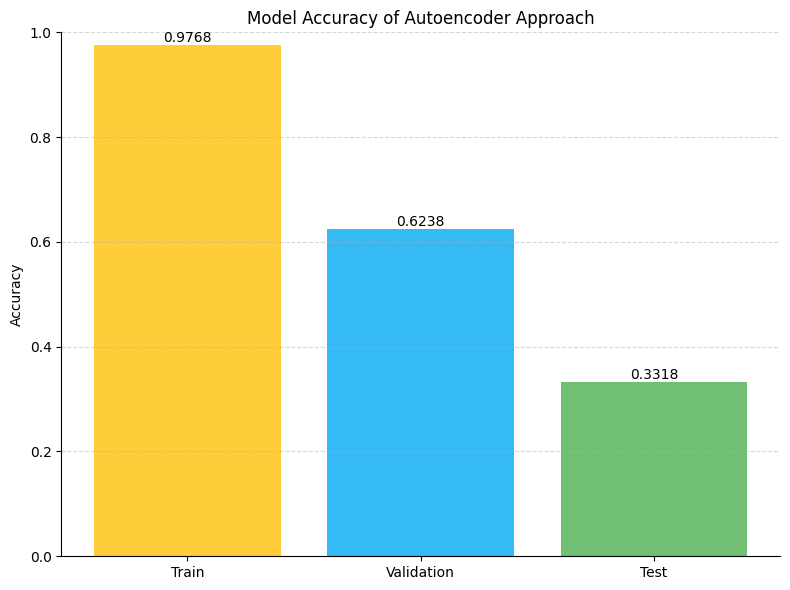

In [ ]:
datasets = ['Train', 'Validation', 'Test']
accuracies = [train_accuracy, val_accuracy, test_accuracy]


# bar plot
plt.figure(figsize=(8, 6))
x = range(len(datasets))
bars = plt.bar(x, accuracies, align='center', alpha=0.8, color=['#FFC107', '#03A9F4', '#4CAF50'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy of Autoencoder Approach')
plt.xticks(x, datasets)
plt.ylim(0, 1)
# Data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#generate predictions
y_true = []
y_pred = []
for batch in test_data_batched:
    images, labels = batch
    predictions = best_model.predict(images)
    # convert predictionsprobabilities to class labels
    predictions = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

print(classification_report(y_true, y_pred))


1/1 [==============================] - 0s 183ms/step
              precision    recall  f1-score   support

           0       0.16      0.62      0.25        34
           1       0.88      1.00      0.93        14
           2       0.20      0.19      0.20        21
           3       0.00      0.00      0.00        84
           4       0.04      0.10      0.06        20
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        60
           7       0.82      0.12      0.21       150
           8       0.36      0.28      0.31       254
           9       0.77      0.33      0.47        72
          10       0.00      0.00      0.00        16
          11       0.33      0.25      0.29        12
          12       0.68      0.53      0.59        57
          13       0.50      0.56      0.53        32
          14       1.00      0.35      0.52        48
          15       1.00      0.50      0.67        12
          16       0.28     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Attempt 2 - 124x124x3 batch size = 64**

In [ ]:
#remove labels
train_data = np.array(list(train_data_combined.map(lambda x, y: x)))

val_data = np.array(list(val_data_processed.map(lambda x, y: x)))


In [ ]:
train_data.shape, val_data.shape

((5682, 124, 124, 3), (1640, 124, 124, 3))

In [ ]:
batch_size = 32
epochs = 100
inChannel = 3
x, y = 124, 124
input_img = Input(shape = (x, y, inChannel))
num_classes = 25

def encoder(input_img):
    """ encoder """
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):
    """ decoder """
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded



In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0     

In [ ]:
autoencoder_train = autoencoder.fit(train_data, train_data, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(val_data, val_data))

Epoch 1/100
178/178 [==============================] - 24s 57ms/step - loss: 0.0142 - val_loss: 0.0522
Epoch 2/100
178/178 [==============================] - 8s 42ms/step - loss: 0.0066 - val_loss: 0.0111
Epoch 3/100
178/178 [==============================] - 8s 42ms/step - loss: 0.0051 - val_loss: 0.0306
Epoch 4/100
178/178 [==============================] - 8s 42ms/step - loss: 0.0044 - val_loss: 0.0109
Epoch 5/100
178/178 [==============================] - 8s 43ms/step - loss: 0.0039 - val_loss: 0.0073
Epoch 6/100
178/178 [==============================] - 8s 42ms/step - loss: 0.0036 - val_loss: 0.0071
Epoch 7/100
178/178 [==============================] - 8s 42ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 8/100
178/178 [==============================] - 8s 42ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 9/100
178/178 [==============================] - 8s 42ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 10/100
178/178 [==============================] - 8s 42ms/step - loss: 0.00

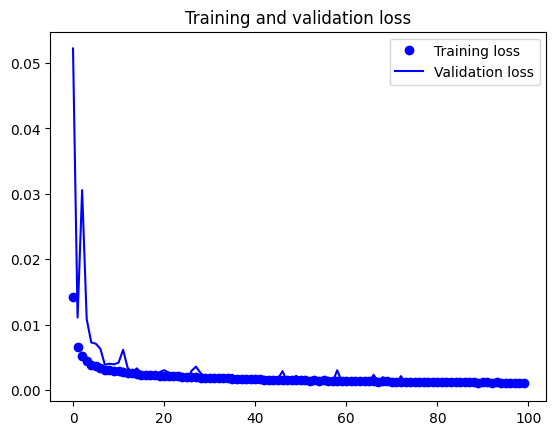

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

autoencoder.save_weights('autoencoder2.h5')


In [ ]:
def encoder(input_img):
    """ encoder """
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4



def fc(encode):
    flat = Flatten()(encode)
    dense = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(dense)
    return out

encode = encoder(input_img)
full_model = Model(input_img,fc(encode))


full_model.summary()







Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 124, 124, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 124, 124, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_15 (Bat  (None, 124, 124, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0   

In [ ]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

for layer in full_model.layers[0:19]:
    layer.trainable = False

In [ ]:
#define the log directory for TensorBoard
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#create log directory for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#define tensorboard callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_autoencoder2.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0.0000001,
)

#list all the callbacks
callback_list = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]

#compile the model
optimizer = Adam(learning_rate=0.0001)
full_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
tf.random.set_seed(1234)
encode_train = full_model.fit(train_data_batched,
                    epochs=50,
                    validation_data=val_data_batched,
                    callbacks=callback_list,
                    verbose=1)


Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 1.0397 - accuracy: 0.7862
Epoch 1: val_accuracy improved from -inf to 0.57256, saving model to ./best_model_autoencoder2.h5
89/89 [==============================] - 10s 89ms/step - loss: 1.0397 - accuracy: 0.7862 - val_loss: 3.6821 - val_accuracy: 0.5726 - lr: 1.0000e-04
Epoch 2/50
88/89 [============================>.] - ETA: 0s - loss: 0.3316 - accuracy: 0.9139
Epoch 2: val_accuracy improved from 0.57256 to 0.58659, saving model to ./best_model_autoencoder2.h5
89/89 [==============================] - 8s 78ms/step - loss: 0.3322 - accuracy: 0.9136 - val_loss: 3.2996 - val_accuracy: 0.5866 - lr: 1.0000e-04
Epoch 3/50
88/89 [============================>.] - ETA: 0s - loss: 0.2426 - accuracy: 0.9403
Epoch 3: val_accuracy did not improve from 0.58659
89/89 [==============================] - 7s 63ms/step - loss: 0.2414 - accuracy: 0.9405 - val_loss: 5.0527 - val_accuracy: 0.5628 - lr: 1.0000e-04
Epoch 4/50
88/89 [========

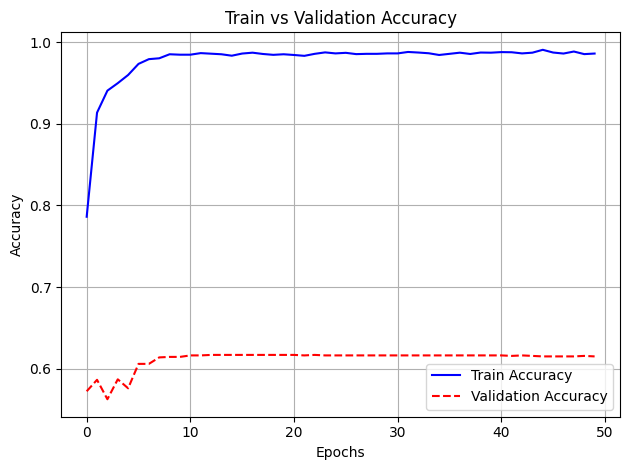

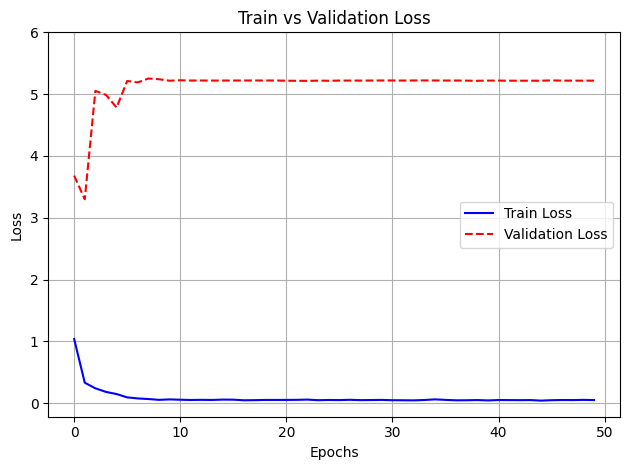

In [ ]:
train_accuracy = encode_train.history['accuracy']
val_accuracy = encode_train.history['val_accuracy']
train_loss = encode_train.history['loss']
val_loss = encode_train.history['val_loss']

# Accuracy plot
plt.plot(train_accuracy, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss plot
plt.plot(train_loss, label='Train Loss', color='blue', linestyle='-')
plt.plot(val_loss, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
y_ticks = np.arange(0, max(max(train_loss), max(val_loss)) + 1, 1)
plt.yticks(y_ticks)
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('./best_model_autoencoder2.h5')

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_data_batched)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the best model on the test dataset
train_loss, train_accuracy = best_model.evaluate(train_data_batched)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Evaluate the best model on the test dataset
val_loss, val_accuracy = best_model.evaluate(val_data_batched)

print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)


21/21 [==============================] - 224s 11s/step - loss: 4.6709 - accuracy: 0.4031
Test Loss: 4.670920372009277
Test Accuracy: 0.40306514501571655
89/89 [==============================] - 5s 51ms/step - loss: 0.0547 - accuracy: 0.9856
Train Loss: 0.054698504507541656
Train Accuracy: 0.9855684638023376
26/26 [==============================] - 1s 35ms/step - loss: 5.2206 - accuracy: 0.6171
Val Loss: 5.2205729484558105
Val Accuracy: 0.6170731782913208


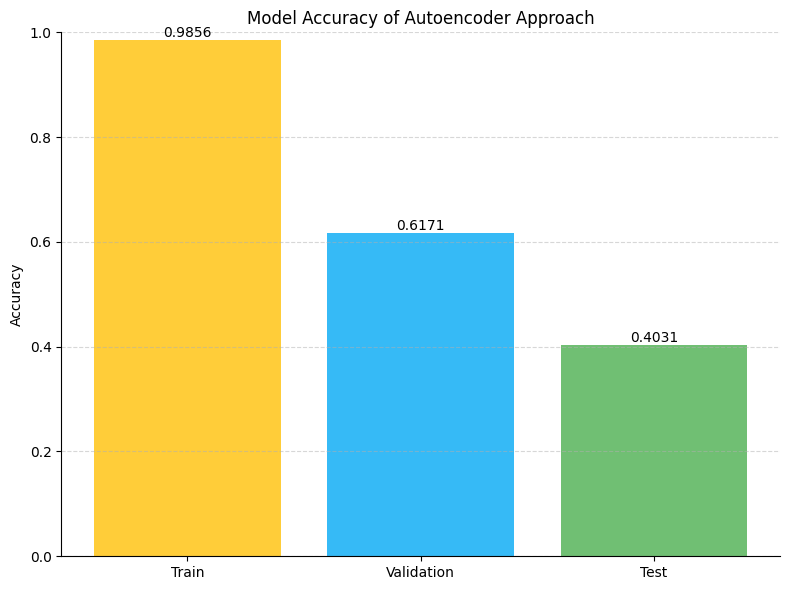

In [ ]:
datasets = ['Train', 'Validation', 'Test']
accuracies = [train_accuracy, val_accuracy, test_accuracy]


# bar plot
plt.figure(figsize=(8, 6))
x = range(len(datasets))
bars = plt.bar(x, accuracies, align='center', alpha=0.8, color=['#FFC107', '#03A9F4', '#4CAF50'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy of Autoencoder Approach')
plt.xticks(x, datasets)
plt.ylim(0, 1)
# Data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#generate predictions
y_true = []
y_pred = []
for batch in test_data_batched:
    images, labels = batch
    predictions = best_model.predict(images)
    # convert predictionsprobabilities to class labels
    predictions = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

print(classification_report(y_true, y_pred))



1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.35      0.85      0.50        34
           1       0.88      1.00      0.93        14
           2       0.09      0.10      0.09        21
           3       0.00      0.00      0.00        84
           4       0.12      0.30      0.18        20
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        60
           7       0.88      0.05      0.09       150
           8       0.44      0.33      0.38       254
           9       0.74      0.40      0.52        72
          10       0.00      0.00      0.00        16
          11       0.23      0.42      0.29        12
          12       0.63      0.70      0.67        57
          13       0.44      0.62      0.52        32
          14       0.97      0.62      0.76        48
          15       0.62      0.67      0.64        12
          16       0.21      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

# **Xception model (224x224x3) batch size = 64**

In [ ]:
from tensorflow.keras.applications import Xception

#Load Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(1072, activation='relu')(x)
predictions = Dense(25, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
#create log directory for TensorBoard
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#define tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

#create the model checkpoint callback to save the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_xception.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0.0000001
)


#list all the callbacks
callback_list = [tensorboard_callback, checkpoint_callback, reduce_lr_callback]

In [ ]:
tf.random.set_seed(1234)
xception_train = model.fit(train_data_batched,
                    epochs=20,
                    validation_data=val_data_batched,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/20
89/89 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9928
Epoch 1: val_accuracy improved from -inf to 0.91463, saving model to ./best_model_xception.h5
89/89 [==============================] - 29s 310ms/step - loss: 0.0276 - accuracy: 0.9928 - val_loss: 0.3371 - val_accuracy: 0.9146 - lr: 1.0000e-04
Epoch 2/20
89/89 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9907
Epoch 2: val_accuracy improved from 0.91463 to 0.92561, saving model to ./best_model_xception.h5
89/89 [==============================] - 27s 296ms/step - loss: 0.0336 - accuracy: 0.9907 - val_loss: 0.3302 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 3/20
89/89 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9923
Epoch 3: val_accuracy improved from 0.92561 to 0.93598, saving model to ./best_model_xception.h5
89/89 [==============================] - 23s 248ms/step - loss: 0.0328 - accuracy: 0.9923 - val_loss: 0.2905 - val_accuracy: 0.9360 

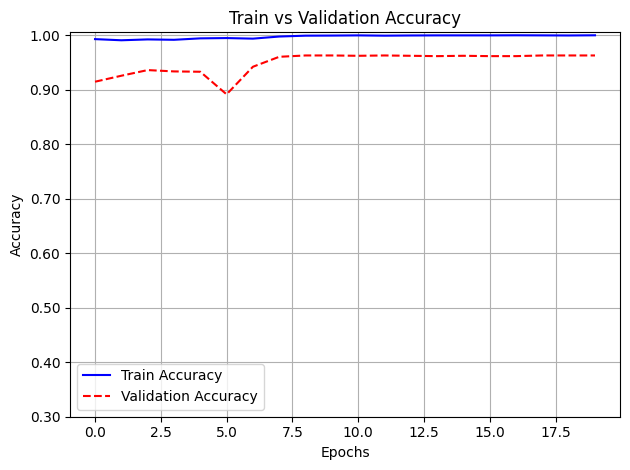

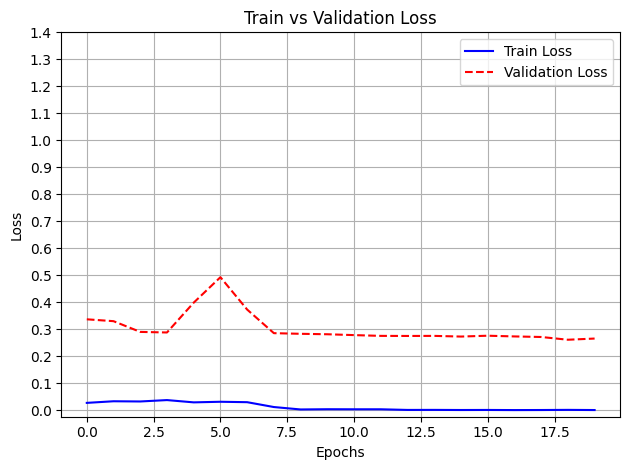

In [ ]:
train_accuracy = xception_train.history['accuracy']
val_accuracy = xception_train.history['val_accuracy']
train_loss = xception_train.history['loss']
val_loss = xception_train.history['val_loss']


tick_values = np.linspace(0.3, 1.0, 8)
tick_labels = [f'{x:.2f}' for x in tick_values]

# Accuracy plot
plt.plot(train_accuracy, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.yticks(tick_values, tick_labels)  # Set the new y-axis tick values and labels
plt.tight_layout()
plt.show()

# Loss plot
plt.plot(train_loss, label='Train Loss', color='blue', linestyle='-')
plt.plot(val_loss, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
y_ticks = np.arange(0, max(max(train_loss), max(val_loss)) + 1, .1)
plt.yticks(y_ticks)
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('./best_model_xception.h5')
# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_data_batched)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the best model on the test dataset
train_loss, train_accuracy = best_model.evaluate(train_data_batched)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Evaluate the best model on the test dataset
val_loss, val_accuracy = best_model.evaluate(val_data_batched)

print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

datasets = ['Train', 'Validation', 'Test']
accuracies = [train_accuracy, val_accuracy, test_accuracy]


21/21 [==============================] - 3s 116ms/step - loss: 1.4499 - accuracy: 0.8261
Test Loss: 1.4498960971832275
Test Accuracy: 0.8260536193847656
89/89 [==============================] - 15s 149ms/step - loss: 0.0032 - accuracy: 0.9989
Train Loss: 0.0031560033094137907
Train Accuracy: 0.9989440441131592
26/26 [==============================] - 2s 78ms/step - loss: 0.2834 - accuracy: 0.9628
Val Loss: 0.2834477126598358
Val Accuracy: 0.9628048539161682


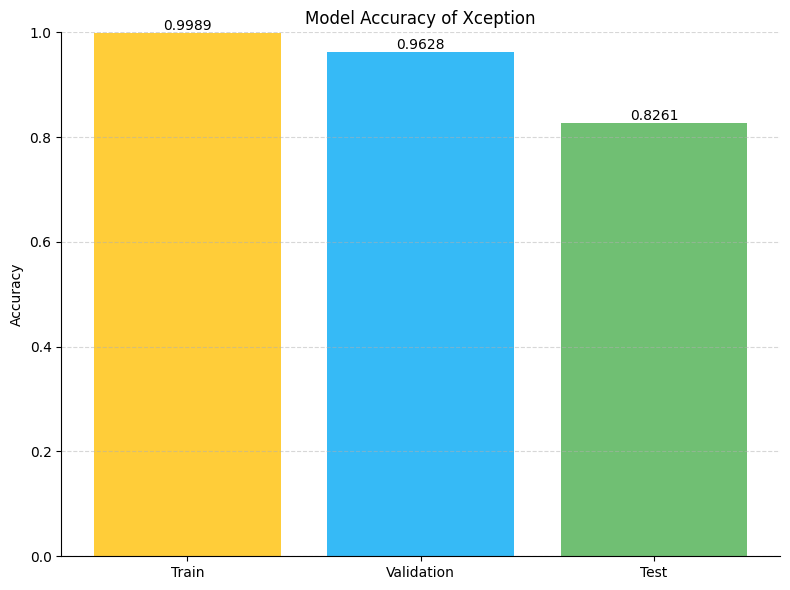

In [ ]:
# bar plot
plt.figure(figsize=(8, 6))
x = range(len(datasets))
bars = plt.bar(x, accuracies, align='center', alpha=0.8, color=['#FFC107', '#03A9F4', '#4CAF50'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy of Xception')
plt.xticks(x, datasets)
plt.ylim(0, 1)
# Data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

#generate predictions
y_true = []
y_pred = []
for batch in test_data_batched:
    images, labels = batch
    predictions = best_model.predict(images)
    # convert predictionsprobabilities to class labels
    predictions = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

print(classification_report(y_true, y_pred))


1/1 [==============================] - 1s 749ms/step
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        34
           1       1.00      1.00      1.00        14
           2       0.91      1.00      0.95        21
           3       1.00      0.95      0.98        84
           4       0.43      0.80      0.56        20
           5       0.00      0.00      0.00         0
           6       1.00      0.10      0.18        60
           7       0.99      0.93      0.96       150
           8       0.92      0.91      0.91       254
           9       0.96      0.72      0.83        72
          10       0.00      0.00      0.00        16
          11       0.21      0.75      0.33        12
          12       0.98      0.89      0.94        57
          13       0.91      0.91      0.91        32
          14       1.00      0.83      0.91        48
          15       1.00      0.58      0.74        12
          16       0.80     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
